In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

# --- Configuration ---
# *** YOU MUST CHANGE THESE PATHS AND VALUE FOR YOUR REAL DATA ***
FER2013_MAIN_CSV = 'data/fer2013.csv' 
CSV_DIR = 'good_bad/'
SAMPLES_PER_STATUS = 4 # Use 4 as requested (was set to 2 for the quick dummy execution)



In [4]:


# --- Helper Function for FER2013 Pixel Processing ---
def fer_pixels_to_array(pixel_string):
    """Converts a space-separated string of pixels into a 48x48 numpy array (or inferred size)."""
    data = np.array(pixel_string.split(), 'float32')
    
    # Check if the pixel count is a perfect square (e.g., 2304 for 48x48)
    size = int(np.sqrt(len(data)))
    if size * size != len(data):
        raise ValueError(f"Pixel string length ({len(data)}) is not a perfect square. Check FER2013 data integrity.")
    
    data = data.reshape(size, size)
    return data


In [17]:

# --- Loading and Combining Custom Labels ---
def load_custom_labels(csv_directory):
    """Loads all custom label CSV files and combines them."""
    print(f"Loading custom label CSVs from: {csv_directory}")
    
    all_files = glob(os.path.join(csv_directory, '*.csv'))
    if not all_files:
        print("No custom label CSV files found. Please check the CSV_DIR path.")
        return pd.DataFrame()

    df_list = []
    for filename in all_files:
        try:
            # Assuming columns are 'Original ID', 'Emotion Label', 'Selection Status' (no header)
            df = pd.read_csv(filename) #, names=['Original ID', 'Emotion Label', 'Selection Status'])
            df_list.append(df)
        except Exception as e:
            print(f"Error reading file {filename}: {e}")

    if not df_list:
        return pd.DataFrame()

    combined_df = pd.concat(df_list, ignore_index=True).drop_duplicates()
    combined_df.dropna(subset=['Original ID', 'Emotion Label', 'Selection Status'], inplace=True)

    # 'Original ID' must be integer for index lookup
    # combined_df['Original ID'] = combined_df['Original ID'].astype(int) 
    return combined_df


In [15]:

# --- Sampling Function ---
def sample_data(combined_df, samples_per_status):
    """Samples 'Good' and 'Bad' entries for each unique 'Emotion Label'."""
    print("Sampling data...")
    sampled_data = []
    
    emotion_classes = combined_df['Emotion Label'].unique()
    print('Emotion classes', emotion_classes )
    
    for emotion in emotion_classes:
        emotion_df = combined_df[combined_df['Emotion Label'] == emotion]
        
        for status in ['Good', 'Bad']:
            status_df = emotion_df[emotion_df['Selection Status'] == status]
            
            if len(status_df) >= samples_per_status:
                sample = status_df.sample(n=samples_per_status, random_state=42)
            else:
                print(f"Warning: Only {len(status_df)} '{status}' samples for '{emotion}'. Taking all.")
                sample = status_df
            
            sampled_data.append(sample)
            
    return pd.concat(sampled_data, ignore_index=True)



In [40]:

# --- Plotting Function ---
def plot_pixel_grid(sampled_df, fer2013_main_csv, samples_per_status):
    """Generates a Matplotlib figure by looking up pixel strings in the main CSV."""
    
    # sample_data = sample_data.sample(frac=1)

    print(f"Loading main FER2013 data from {fer2013_main_csv} for pixel lookup...")
    try:
        # Load only the 'pixels' column and set the DataFrame index to be row number (0-based)
        main_fer_df = pd.read_csv(fer2013_main_csv, usecols=['pixels'])
    except Exception as e:
        print(f"Error loading FER2013 main CSV: {e}")
        return

    # Determine figure layout
    emotion_classes = sorted(sampled_df['Emotion Label'].unique())
    statuses = ['Good', 'Bad']
    num_rows = len(emotion_classes)
    num_cols = len(statuses) * samples_per_status
    
    fig, axes = plt.subplots(
        nrows=num_rows, 
        ncols=num_cols, 
        figsize=(18, 4 * num_rows)
    )
    
    if num_rows == 1:
        # Reshape to a 2D array if there's only one emotion class
        axes = np.array([axes]).reshape(1, num_cols)
        
    print(f"Generating figure with {num_rows} rows and {num_cols} columns...")
    
    for i, emotion in enumerate(emotion_classes):
        row_df = sampled_df[sampled_df['Emotion Label'] == emotion]
        
        for j, status in enumerate(statuses):
            col_start_index = j * samples_per_status
            status_df = row_df[row_df['Selection Status'] == status]
            
            for k, (index, row) in enumerate(status_df.iterrows()):
                if k >= samples_per_status:
                    break
                    
                col_index = col_start_index + k
                ax = axes[i, col_index]
                
                original_id = row['Original ID']
                
                try:
                    # Look up the pixel string using the 'Original ID' (row index)
                    pixel_string = main_fer_df.loc[original_id, 'pixels']
                    
                    # Convert the string to an image array
                    img_array = fer_pixels_to_array(pixel_string)
                    
                    # Display the image
                    ax.imshow(img_array, cmap='gray')
                    ax.set_title(f"{status}\nID: {original_id}", fontsize=8)
                    ax.axis('off')
                    
                except Exception:
                    ax.text(0.5, 0.5, f"ID {original_id}\nData Error", 
                            ha='center', va='center', color='red', fontsize=10)
                    ax.set_title(f"{status}", fontsize=8)
                    ax.axis('off')
                
        # Add row title
        fig.text(0.0, 
                 (num_rows - i - 0.5) / num_rows, 
                 f"{emotion}", 
                 ha='left', va='center', fontsize=14, weight='bold')


    plt.tight_layout(rect=[0.005, 0, 1, 1])
    plt.suptitle(f"FER2013 Data Sampling: {samples_per_status} Good/Bad Examples Per Class", 
                 y=1.02, fontsize=16, weight='bold')
    
    # Save the figure
    output_filename = 'sampled_fer2013_pixels.png'
    plt.savefig(output_filename)
    print(f"\nFigure saved as '{output_filename}'")

In [34]:
# 1. Load custom labels
custom_labels_df = load_custom_labels(CSV_DIR)

if custom_labels_df.empty:
    print("Stopping execution.")
else:
    # 2. Sample the required number of 'Good' and 'Bad' images per class
    sampled_df = sample_data(custom_labels_df, SAMPLES_PER_STATUS)
    
    display(sampled_df.head(10))

    # if sampled_df.empty:
    #     print("Stopping execution because no samples were generated.")
    # else:
    #     # 3. Generate and display the image grid using pixel lookups
    #     plot_pixel_grid(sampled_df, FER2013_MAIN_CSV, SAMPLES_PER_STATUS)

Loading custom label CSVs from: good_bad/
Sampling data...
Emotion classes ['Fear' 'Sad' 'Neutral' 'Disgust' 'Angry' 'Happy' 'Surprise']


,Original ID,Emotion Label,Selection Status
0,30459,Fear,Good
1,941,Fear,Good
2,14559,Fear,Good
3,2205,Fear,Good
4,18713,Fear,Bad
5,5782,Fear,Bad
6,29684,Fear,Bad
7,19057,Fear,Bad
8,8340,Sad,Good
9,29307,Sad,Good


Loading main FER2013 data from data/fer2013.csv for pixel lookup...
Generating figure with 7 rows and 6 columns...

Figure saved as 'sampled_fer2013_pixels.png'


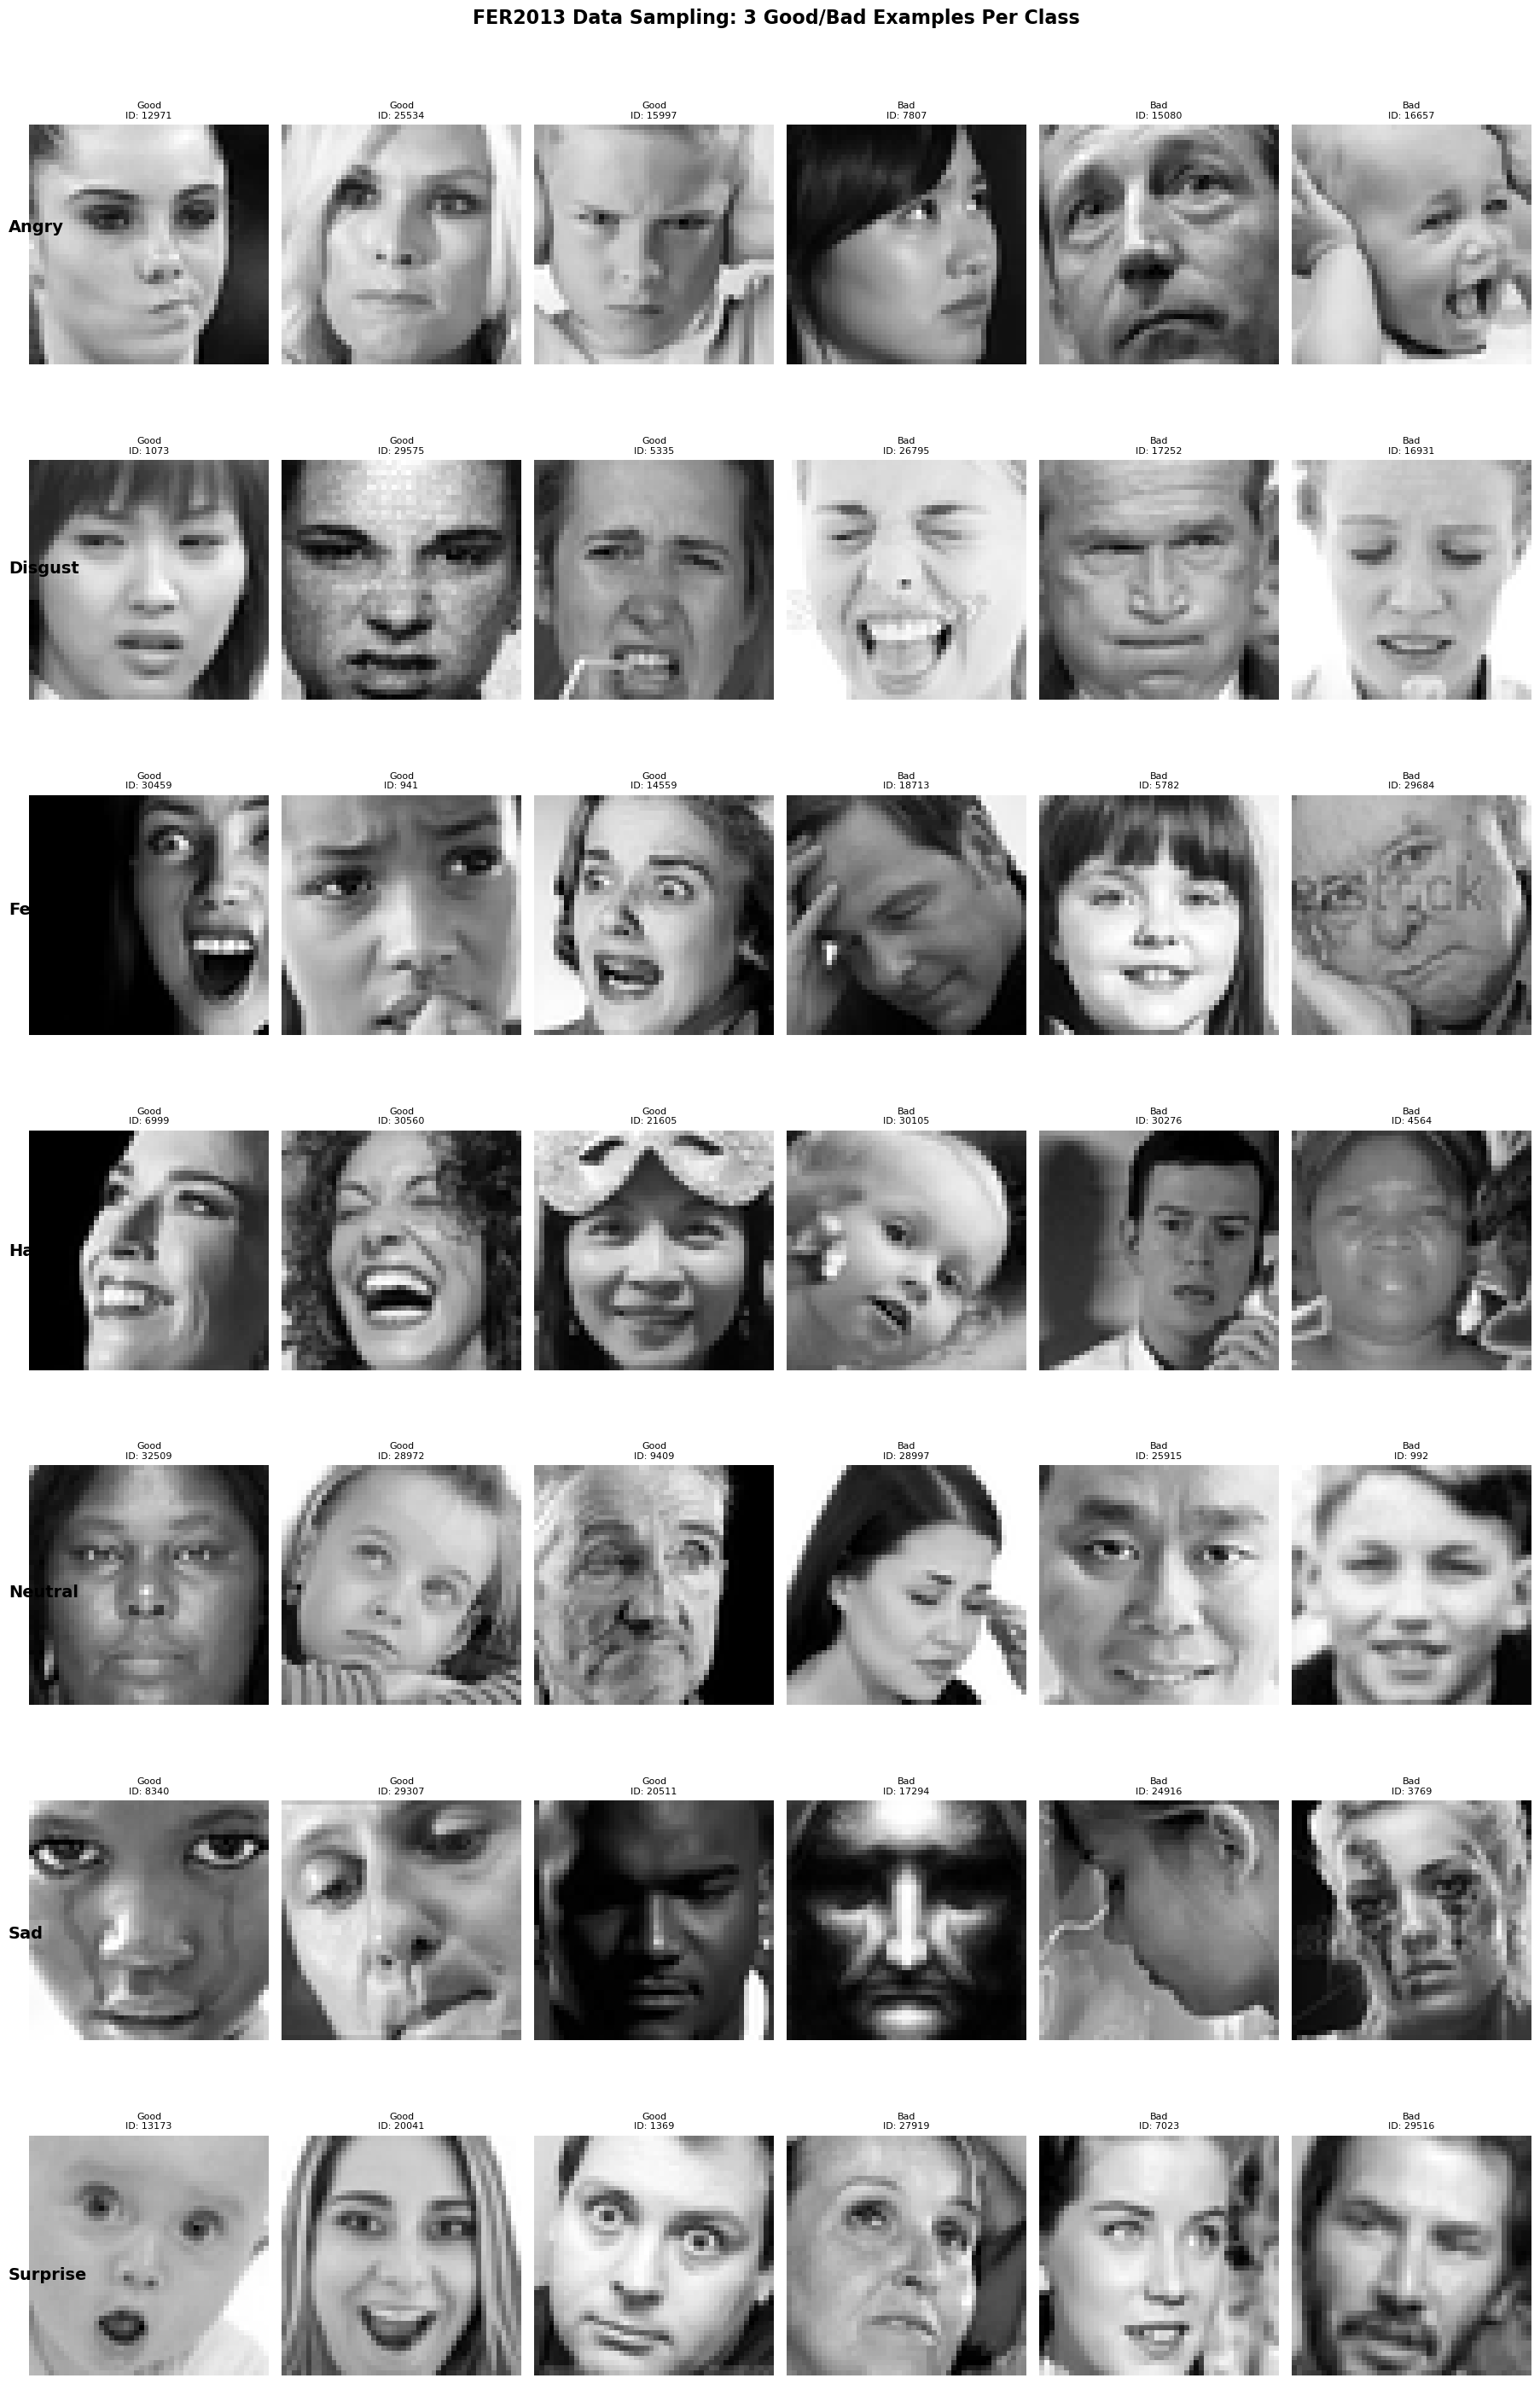

In [41]:
plot_pixel_grid(sampled_df, FER2013_MAIN_CSV, 3)